## Modules

In [1]:
import os
from tqdm import tqdm

import numpy as np
from scipy.signal import find_peaks, correlate, butter, sosfilt, freqs
from scipy.ndimage import gaussian_filter, median_filter, shift, minimum_filter1d, gaussian_filter1d
from skimage.registration import phase_cross_correlation
from scipy.stats import sem, zscore

import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt
from matplotlib import colormaps as clm

from PIL import Image
import tifffile as tff

cmap = 'cmc.batlow'
# sns.set_palette(cmap)

### Open data

In [2]:
# pathBase = r"Z:\gGermain\2024_09_12\4"
pathBase = r"Z:\gGermain\2024-09-17\3"
# N = 2
# green = np.loadtxt(pathBase + "\\530_{}.csv".format(N), skiprows=1, delimiter=',')[:,1]
# violet = np.loadtxt(pathBase + "\\405_{}.csv".format(N), skiprows=1, delimiter=',')[:,1]
# blue = np.loadtxt(pathBase + "\\470_{}.csv".format(N), skiprows=1, delimiter=',')[:,1]

green = np.loadtxt(pathBase + "\\530.csv", skiprows=1, delimiter=',')[:,1]
# violet = np.loadtxt(pathBase + "\\405.csv", skiprows=1, delimiter=',')[:,1]
blue = np.loadtxt(pathBase + "\\470.csv", skiprows=1, delimiter=',')[:,1]

sigs = (blue, green)

green_t = np.load(pathBase + "\\530ts.npy")
# violet_t = np.load(pathBase + "\\405ts.npy")
blue_t = np.load(pathBase + "\\470ts.npy")


### AP series

In [3]:
# FPS = 50
AP_idx = []
# nChannels=5
# AP_begin = 5
# percycle=15
# FPSc = FPS/nChannels
# framespcycles = int(FPSc*percycle)
# ncycles = int(len(violet_t)//framespcycles)
# AP_times = np.array(list(range(ncycles)))*15+5
AP_times = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
       132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
       239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
       335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
       456.7 ,  468.25])

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(blue_t-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(blue_t))
AP_series[AP_idx] = 1

In [4]:

## ALIGN DATA
inf = 30
sup = 100
aligned_data_raw = np.zeros((len(sigs), len(AP_idx), inf+sup))
aligned_data_norm = np.zeros((len(sigs), len(AP_idx), inf+sup))
for idx, sig in enumerate(sigs):
  for i in range(len(AP_idx)):
    plage = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
    aligned_data_raw[idx,i,:] = plage
    aligned_data_norm[idx,i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))

  aligned_data = aligned_data_raw


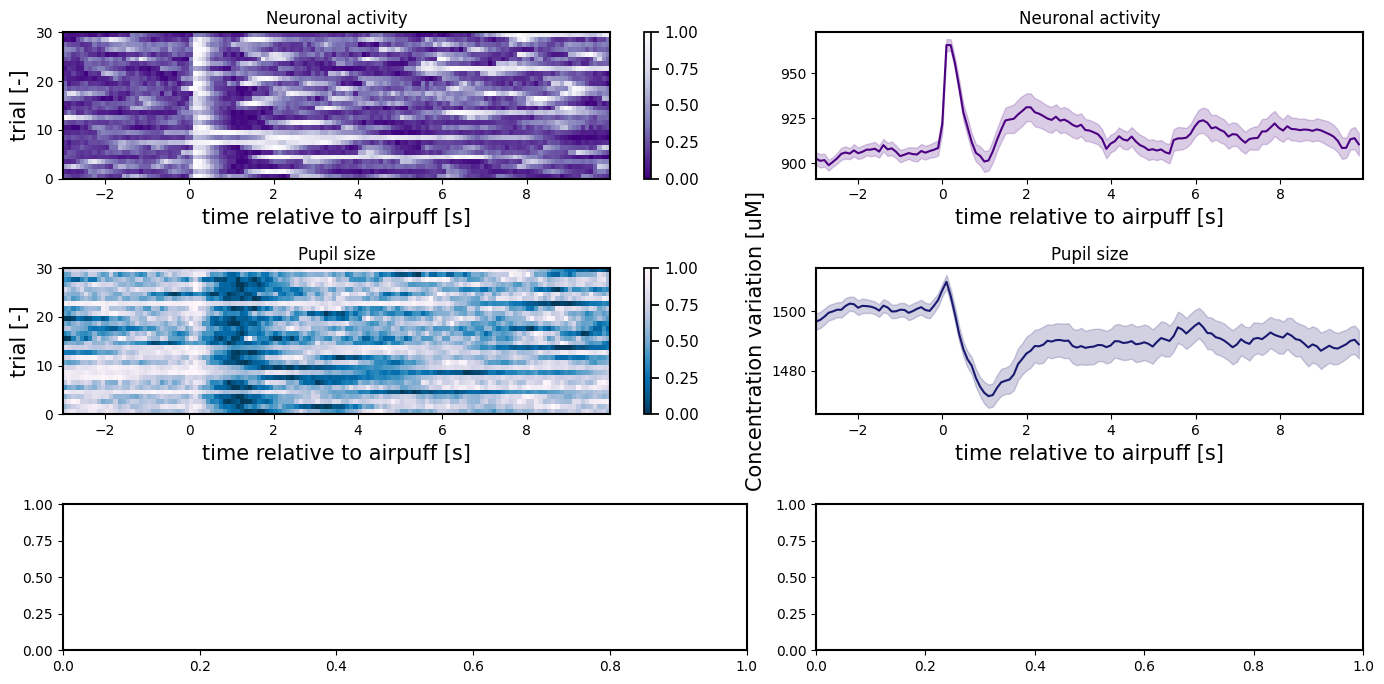

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(14,7), width_ratios=[5, 4])
sns.set_context('notebook')

titles = ("Neuronal activity", "Pupil size", "Blink")
cols = ('indigo', 'midnightblue', 'midnightblue')
cmaps = (clm['Purples_r'], clm['PuBu_r'], clm['PuBu_r'])
time = blue_t

for idx, (sig, cmap, title) in enumerate(zip(aligned_data, cmaps, titles)):
  ax = plt.subplot(3, 2, 2*idx+1)
  ax.set_title(title)
  ax.set_xlabel('time relative to airpuff [s]')
  ax.set_ylabel("trial [-]")
  pos = ax.imshow(aligned_data_norm[idx,:,:], origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, len(AP_times)], aspect='auto', cmap=cmap)
  fig.colorbar(pos, ax=ax)

for idx, (sig, col, title) in enumerate(zip(aligned_data_raw, cols, titles)):
    avg_data = np.mean(sig, axis=0)
    std_data = sem(sig, axis=0)

    ax = plt.subplot(3, 2, 2*idx+2)
    ax.set_title(title)
    # ax.vlines(0, avg_data.min(), avg_data.max(), color='grey', linestyles='-')
    ax.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
    ax.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])
    ax.set_xlabel('time relative to airpuff [s]')
    if idx == 1:
        ax.set_ylabel("Concentration variation [uM]")
    # sns.despine()
    plt.tight_layout()

## frames analysis

In [2]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files = [os.path.join(path, f) for f in files]
    files.sort(key=lambda x: os.path.getmtime(x))
    return files


def resample_pixel_value(data, bits):
    plage = 2**bits - 1
    return (plage * (data - np.min(data))/(np.max(data - np.min(data))))


def save_as_tiff(frames, prefixe, save_path):
    """_summary_

    Args:
        frames (array): 3D array of one type of data, ex HbO, HbR, or HbT
        prefixe (str): type of data
        save_path (str): folder to save data
    """
    for idx, frame in tqdm(enumerate(frames)):
        im = Image.fromarray(frame, mode='I;16')
        im.save(save_path + "\\{}.tiff".format(prefixe + str(idx)), "TIFF")

def create_list_trials(frames_timestamps:list, event_times:list): 
    """Creates a list of indices for frames of a same air puff trial, separated for each airpuff, with 3 seconds before, and 10 seconds after the airpuff.

    Args:
        frames_timestamps (list): array containing the timestamps of all the frames for one channel
        event_times (list): array containing the time stamps for the air puff delivery

    Returns:
        list: a list containing all the indices of the frames, sorted by air puff
    """

    AP_idx = []
    for ti in event_times:
        AP_idx.append(np.argmin(np.absolute(frames_timestamps-ti)))

    AP_idx = AP_idx[:-1]
    Nf_bef = 3*10
    Nf_aft = 10*10

    sorted_frames_idx = []
    for idx in AP_idx:
        trial_idx = [idx-Nf_bef, idx+Nf_aft]
        sorted_frames_idx.append(trial_idx)

    return sorted_frames_idx



def create_npy_stack(folder_path:str, save_path:str,  wl:int, saving=False):
    """creates a 3D npy stack of raw tiff images

    Args:
        folder_path (str): folder containing tiff frames
        save_path (str): folder to save npy stack
        wl (int): wavelength for saved file name
    """
    files = identify_files(folder_path, "tif")
    # files=files[:250]
    for idx, file in tqdm(enumerate(files)):
        # frame = tff.TiffFile(folder_path+"\\"+file).asarray()
        frame = tff.TiffFile(file).asarray()
        if idx == 0:
            num_frames = len(files)
            frame_shape = frame.shape
            stack_shape = (num_frames, frame_shape[0], frame_shape[1])
            _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
        _3d_stack[idx,:,:] = frame

    if saving:
        np.save(save_path+"\\{}_rawStack.npy".format(wl), _3d_stack)
    return _3d_stack


In [3]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files = [os.path.join(path, f) for f in files]
    files.sort(key=lambda x: os.path.getmtime(x))
    return files


def resample_pixel_value(data, bits):
    plage = 2**bits - 1
    return (plage * (data - np.min(data))/(np.max(data - np.min(data))))


def save_as_tiff(frames, prefixe, save_path):
    """_summary_

    Args:
        frames (array): 3D array of one type of data, ex HbO, HbR, or HbT
        prefixe (str): type of data
        save_path (str): folder to save data
    """
    for idx, frame in tqdm(enumerate(frames)):
        im = Image.fromarray(frame, mode='I;16')
        im.save(save_path + "\\{}.tiff".format(prefixe + str(idx)), "TIFF")


def create_list_trials(frames_timestamps:list, event_times:list, FPS:int=10): 
    """Creates a list of indices for frames of a same air puff trial, separated for each airpuff, with 3 seconds before, and 10 seconds after the airpuff.

    Args:
        frames_timestamps (list): array containing the timestamps of all the frames for one channel
        event_times (list): array containing the time stamps for the air puff delivery
        FPS (int): integer of the framerate or frequency of acquisition for one channel. Defaults to 10.

    Returns:
        list: a list containing all the indices of the frames, sorted by air puff
    """

    AP_idx = []
    for ti in event_times:
        AP_idx.append(np.argmin(np.absolute(frames_timestamps-ti)))

    AP_idx = AP_idx[:-1]
    Nf_bef = 3*FPS
    Nf_aft = 10*FPS

    sorted_frames_idx = []
    for idx in AP_idx:
        trial_idx = [idx-Nf_bef, idx+Nf_aft]
        sorted_frames_idx.append(trial_idx)

    return sorted_frames_idx



def create_npy_stack(folder_path:str, save_path:str,  wl:int, saving=False, cutAroundEvent=None):
    """creates a 3D npy stack of raw tiff images

    Args:
        folder_path (str): folder containing tiff frames
        save_path (str): folder to save npy stack
        wl (int): wavelength for saved file name
    """

    if cutAroundEvent is not None:
        files = cutAroundEvent
    
    else:
        files = identify_files(folder_path, "tif")
    
    # files=files[:250]
    for idx, file in tqdm(enumerate(files)):
        frame = tff.TiffFile(file).asarray()
        if idx == 0:
            num_frames = len(files)
            frame_shape = frame.shape
            stack_shape = (num_frames, frame_shape[0], frame_shape[1])
            _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
        _3d_stack[idx,:,:] = frame

    if saving:
        np.save(save_path+"\\{}_rawStack.npy".format(wl), _3d_stack)
    return _3d_stack


def motion_correction(still_frame, frames):
    """Applies motion correction based on a phase cross correlation

    Args:
        frames (_type_): 3D array of frames before correction

    Returns:
        _type_: 3D array of frames after correction
    """
    fixed_frame = still_frame
    motion_corrected = np.zeros((frames.shape), dtype=np.uint16)
    for idx, frame in tqdm(enumerate(frames)):
        if idx == 0:
            motion_corrected[0,:,:] = frame
            continue
        shifted, error, diffphase = phase_cross_correlation(fixed_frame, frame, upsample_factor=10)
        corrected_image = shift(frame, shift=(shifted[0], shifted[1]), mode='reflect')
        motion_corrected[idx,:,:] = corrected_image
    
    return motion_corrected


def bin_pixels(frames, bin_size=2):
    """Bins pixels with bin size

    Args:
        frames (array): 3D array of frames. 
        bin_size (int, optional): size of pixel bins. Defaults to 2.

    Returns:
        array: 3D array, stack of binned data
    """
    for idx, frame in tqdm(enumerate(frames)):
        if idx == 0:
            height, width = frame.shape[:2]
            binned_height = height // bin_size
            binned_width = width // bin_size
            binned_frames = np.zeros((len(frames), binned_height, binned_width), dtype=np.uint16)

        reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)

        binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
        binned_frame = binned_frame / (bin_size**2)
        binned_frames[idx,:,:] = binned_frame

    return binned_frames


def prepToCompute(frames:list, correct_motion=False, bin_size=None, regress=False):
    """_summary_

    Args:
        frames (list): _description_
        correct_motion (bool, optional): _description_. Defaults to False.
        filter (bool, optional): _description_. Defaults to False.
        bin_size (_type_, optional): _description_. Defaults to None.
        regress (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    if correct_motion:
        print("Correcting motion")
        frames = motion_correction(frames[0,:,:], frames)
    if bin_size is not None:
        print("Bining pixels")
        frames = bin_pixels(frames, bin_size=bin_size)
    if regress:
        print("Normalizing")
        frames = frames/np.mean(frames, axis=0)
    
    return frames


In [ ]:
data_path = r"Z:\gGermain\2024-09-17\3_short"

# blue = create_npy_stack(data_path + "\\470", data_path, 470, saving=True)
# blue_raw = np.load(data_path + "\\470_rawStack.npy")
# blue_raw = prepToCompute(blue, correct_motion=True, bin_size=None)
# green = np.load(data_path + "\\530preped.npy")

blue = blue_raw/green


    ## delF/F analysis
# avg_blue = np.mean(blue, axis=0)
# dFF = (blue-avg_blue)/avg_blue
# plt.imshow(dFF[40])
# plt.show()
# dFF = gaussian_filter(dFF, sigma=2.5, axes=(1))
# # plt.imshow(dFF[40])
# dFF = resample_pixel_value(dFF, 16).astype(np.uint16)
# save_as_tiff(dFF, "GCaMP", data_path + "\\GCaMP")



    ## zcsore analysis
z_blue = zscore(blue, axis=0)
z_blue = gaussian_filter(z_blue, sigma=2, axes=(0))
z_blue = resample_pixel_value(z_blue, 16).astype(np.uint16)
save_as_tiff(z_blue, "GCaMP", data_path+"\\GCaMP_z4")

601it [00:12, 49.90it/s]


## pipeline de cleroux test

In [ ]:
def regress_timeseries(y, x, intercept=False, offset=False):
    """ Regress out the linear contribution of a regressor on time series data
    Args:
        y (ndarray): Time series specified as Nx1 vector. For M time series, specify as NxM array. 
        x (1D vector): NX1 time series to regress out of data.
        intercept (default = True) Specify wether or not to include an intercept term in the regressor.
        offset (default = False) Option to re-offset the regressed data at the estimated intercept
    Returns:
        eps (ndarray): Regressed data
    """
    if np.ndim(y)==1: #Make sure time series are presented as NX1 vectors
        y = y[:,None]
    N = np.shape(y)[0]
    if np.shape(x)[0] != N:
        raise Exception('Regressor must be of height N, with N the number of time points.')
    if np.ndim(x)==1: 
        x = x[:,None]
    if (offset and intercept) is False:
        intercept = True
    if intercept:
        x = np.insert(x,0,np.ones((1,N)),axis = 1)
    x_inv = np.linalg.pinv(x)
    beta = np.matmul(x_inv,y)
    y_est = np.matmul(x,beta)
    eps = y - y_est + np.mean(y)
    if offset:
        eps = eps+np.matmul(x[:,0][:,None],beta[0,:][None,:])
    return eps

def baseline_minfilter(signal, window=300, sigma1=5, sigma2=100, debug=False):
    signal_flatstart = np.copy(signal)
    signal_flatstart[0] = signal[1]
    smooth = gaussian_filter1d(signal_flatstart, sigma1)
    mins = minimum_filter1d(smooth, window)
    baseline = gaussian_filter1d(mins, sigma2)
    if debug:
        debug_out = np.asarray([smooth, mins, baseline])
        return debug_out
    else:
        return baseline

def compute_dff_using_minfilter(timeseries, window=200, sigma1=0.1, sigma2=50):
    T, M, N = timeseries.shape
    dff = np.zeros((T, M, N))
    
    for m in range(M):
        for n in range(N):
            pixel_timeseries = timeseries[:, m, n]
            
            if np.any(pixel_timeseries):
                baseline = baseline_minfilter(pixel_timeseries, window=window, sigma1=sigma1, sigma2=sigma2)
                dff[:, m, n] = (pixel_timeseries - baseline) / baseline

    return dff

def hemodynamic_regression(folder_path, data_array):
    regressor_array = tff.imread(folder_path+r"\IOI_green.tif")
    regressor_array = regressor_array / np.mean(regressor_array, axis=0)
    
    regressed_data = data_array / regressor_array

    return regressed_data

def calcium_pipeline(folder_path, save_path, baseline=[0, -1], regression=False, hemo_corr=False, bin_pixel=None, filter_data=True):
    print("Loading movie")
    path_blue = save_path + r"\Calcium_imaging.tif"
    data = create_npy_stack(folder_path, folder_path, 470)

    # if len(identify_files(folder_path, ["rawdata_blue"])) == 0:
    #     if len(identify_files(folder_path, ["blueChan"])) == 0:
    #         create_channel(folder_path=folder_path, channel="blue")
    #     data = np.load(folder_path+r"\blueChan.npy").astype(np.float32)
    #     os.remove(folder_path+r"\blueChan.npy")
    #     data /= 4096.0
    #     data = np.flip(data, axis=(1,2))
    #     tff.imwrite(folder_path + r"\rawdata_blue.tif", data)
    # elif len(identify_files(folder_path, ["rawdata_blue"])) != 0:
    #     data = tff.imread(folder_path + r"\rawdata_blue.tif")
        
    # --- Test with transcranial data ---
#     data = np.float32(tf.imread(folder_path + r"\rawdata_gcamp.tif"))
    # ---
    
    data = median_filter(data, size=[5, 1, 1]) 
    
    if bin_pixel is not None:
        print("Pixel binning")
        binned_data = np.empty((data.shape[0], data.shape[1]//2, data.shape[2]//2), dtype=data.dtype)
        for i, frame in enumerate(data):
            binned_data[i] = bin_pixels(frame, bin_pixel)
        data = binned_data
        binned_data = None
    
    if hemo_corr:
        print("Hemodynamic regression")
        data /= np.mean(data, axis=0)
        data = hemodynamic_regression(folder_path, data)
    
    print("delta F/F calculation")
    data = compute_dff_using_minfilter(data, window=200, sigma1=0.9, sigma2=10)
        
    if regression:
        print("Global regression")
        regressor = np.mean(data, axis=(1,2))
        T, N, M = data.shape
        time_series = data.transpose(1, 2, 0).reshape(N * M, T)
        data = None  # release memory
        result = [regress_timeseries(series, regressor) for series in time_series]
        data = np.array(result).reshape(N, M, T).transpose(2, 0, 1)
        result, timeseries, regressor = None, None, None  # release memory
    
    if filter_data:
        data = gaussian_filter1d(data, sigma=0.9, axis=0)
        
    print("Saving data")
    with tff.TiffWriter(path_blue, bigtiff=True) as writer:
        for frame in data:
            writer.write(np.float32(frame), contiguous=True)
    data = None
    
    print("Done")

In [6]:
# biner 3x3 data 2024-09-17

pathBase = r"Z:\gGermain\2024-09-17\3"

pathload = pathBase + "\\470"
pathsave = pathBase + "\\470bined"

files = identify_files(pathload, "tif")
bin_size = 3
for idx, file in tqdm(enumerate(files)):
    if idx == 0:
        frame = tff.TiffFile(file).asarray()
        height, width = frame.shape[:2]
        binned_height = height // bin_size
        binned_width = width // bin_size

    reshaped_frame = frame[:binned_height * bin_size, :binned_width * bin_size].reshape(binned_height, bin_size, binned_width, bin_size)

    binned_frame = np.sum(reshaped_frame, axis=(1, 3), dtype=np.float32)
    binned_frame = binned_frame / (bin_size**2)

    im = Image.fromarray(frame, mode='I;16')
    im.save(pathsave + "\\{}.tiff".format("470_"+ str(idx)), "TIFF")

height, width, binned_height, binned_width, reshaped_frame = None, None, None, None, None

329it [01:00,  5.44it/s]


KeyboardInterrupt: 